<a href="https://colab.research.google.com/github/odesay97/MachineLearing_Class/blob/main/8_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 합성곱 신경망의 시각화

합성곱 층이 이미지에서 어떤 것을 학습했는지 알아보기 위해 합성곱 층의 가중치와 특성 맵을 그림으로 시각화 해보자

합성곱 신경망의 동작 원리에 대한 통찰력을 높일 수 있음

이전 절 (8-2)에서 훈련했던 모델 파라미터가 필요

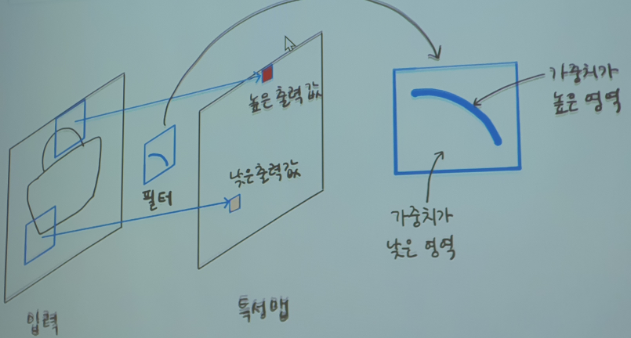

### 가중치 시각화

합성곱 층은 여러개의 필터를 사용해 이미지에서 특징을 학습함

각 필터는 커널이라 부르는 가중치와 절편을 보유

일반적으로 절편은 시각적으로 의미가 없음

가중치는 입력 이미지의 2차원 영역에 적용되어 어떤 특징을 크게 두드러지게 표현하는 역할을 함

예를 들어 둥근 모서리가 있는 영역을 크게 활성화하고 그렇지 않은 영역은 낮은 값을 만듬

즉, 이 필터는 곡선 부분의 가중치 값이 높고 그 외 부분은 가중치 값이 낮을 것임 그래야만 둥근 모서리가 있는 입력과 곱해져서 큰 출력을 만들기 때문


In [4]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다.
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

### 체크 포인트 파일 불러오기

8-2 에서 했던 모델 불러옴 -> 그래서 없다 그러면 휘발된거니까 다시 실행시키고 오셈

In [5]:
# 그냥 저장하면 휘발되므로 내 구글드라이브에 영구저장하기 위해서 내 구글드라이브 마운트 (연결)
from google.colab import drive
drive.mount('/content/driver/')

Drive already mounted at /content/driver/; to attempt to forcibly remount, call drive.mount("/content/driver/", force_remount=True).


In [6]:
from tensorflow import keras
model = keras.models.load_model('/content/driver/MyDrive/best-cnn-model.h5')

케라스 모델에 추가한 층은 layers 속성이 저장되어 있음

In [7]:
model.layers

In [8]:
# 첫번쨰 합성곱 층의 가중치 조사 -> 위에서 Conv2D 층

conv = model.layers[0]

print(conv.weights[0].shape, conv.weights[1].shape)

(3, 3, 1, 32) (32,)


커널의 크기가 (3,3)이고, 합성곱 층에 전달되는 입력의 깊이가 1이므로 실제 커널 크기는 (3,3,1)임

필터 개수가 32개 이므로 weights의 첫번쨰 원소인 가중치의 크기는 (3,3,1,32)

weights의 두번쨰 원소는 절편의 개수를 나타내며 각 필터마다 1개의 절편이 있으므로 (32,)

In [10]:
# 두번쨰 합성곱 층의 가중치 조사 -> 위에서 두번쨰 Conv2D층
conv = model.layers[2]

print(conv.weights[0].shape, conv.weights[1].shape)

(3, 3, 32, 64) (64,)


### 가중치 히스토그램

weights 속성은 텐서플로의 다차원 배열은 Tensor 클래스의 객체임

다루기 쉽도록 넘파이 배열로 변환

먼저 가중치 배열의 평균과 표준편차를 계산하고 히스토그램으로 값을 확인하자

In [11]:
conv_weights = conv.weights[0].numpy()

print(conv_weights.mean(), conv_weights.std(), conv_weights.max(), conv_weights.min())

-0.035053056 0.1455589 0.50660676 -0.8471269


### 가중치의 분포를 히스토그램으로 그려 직관적으로 이해해보자



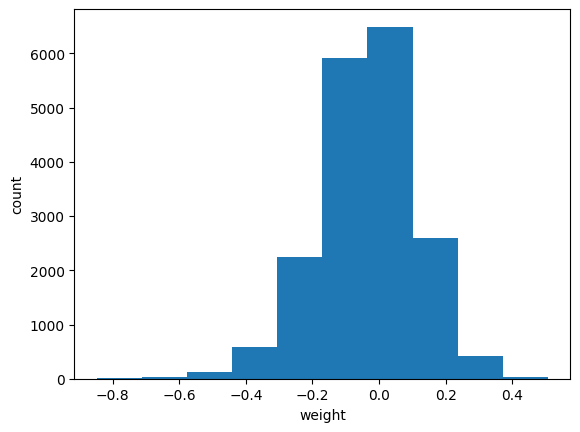

In [12]:
import matplotlib.pyplot as plt

plt.hist(conv_weights.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

히스토그램을 보면 0을 중심으로 종 모양 분포를 띠고 있음

이 가중치는 무엇인가 의미를 학습한 것인가?

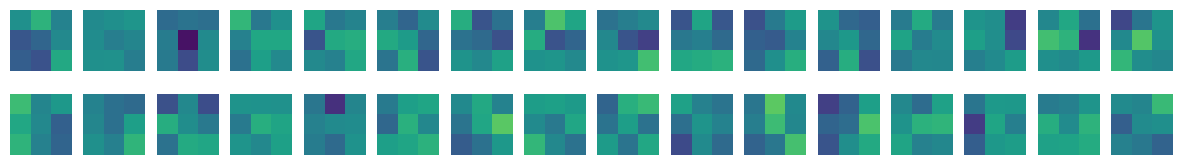

In [15]:
# 32개의 필터를 16개씩 두 줄에 출력
fig, axs = plt.subplots(2, 16, figsize=(15,2)) # figsize는 각 subplots의 크기가 아닌 전체 그림의 크기

for i in range(2):
    for j in range(16):
        axs[i, j].imshow(conv_weights[:,:,0,i*16 + j], vmin=-0.5, vmax=0.5) # vmin, vmax : 색상의 최소값과 최대값을 조정
        axs[i, j].axis('off')
# plt.savefig('aaa.png') # 그림 저장

plt.show()

결과 그래프를 보면 가중치 값이 무작위로 나열된 것이 아닌 어떤 패턴을 볼 수 있음

참고로 밝은 부분의 값이 높음

첫번쨰 줄의 11번째 필터에서 위쪽의 3픽셀의 값이 높음

즉, 이 가중치는 직선을 만나면 크게 활성화될 것임

## 신경망의 가중치는 어떻게 선택될까?

In [16]:
# 훈련하지 않은 빈 합성곱 신경망을 만들고 분석해보자
no_training_model = keras.Sequential()

no_training_model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu',
                                          padding='same', input_shape=(28,28,1)))

no_training_conv = no_training_model.layers[0] # 첫번쨰 층의 가중치를 변수에 저장

print(no_training_conv.weights[0].shape)

(3, 3, 1, 32)


In [17]:
no_training_weights = no_training_conv.weights[0].numpy()

print(no_training_weights.mean(), no_training_weights.std())

0.0053191613 0.08463709


평균은 이전과 동일하게 0에 가깝지만 표준편차는 이전과 달리 매우 작음

또한 최대값과 최소값의 차이도 작음

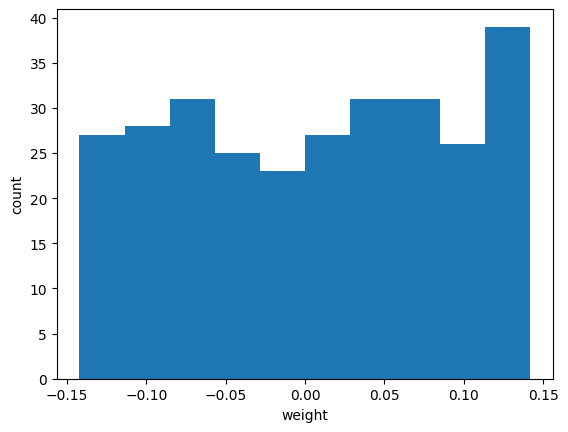

In [18]:
plt.hist(no_training_weights.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

대부분의 가중치가 -0.15~0.15 사이에 존재하며 비교적 고른 분포를 보임

텐서플로가 신경망의 가중치를 처음 초기화할 때 균등 분포에서 랜덤하게 값을 선택하기 때문

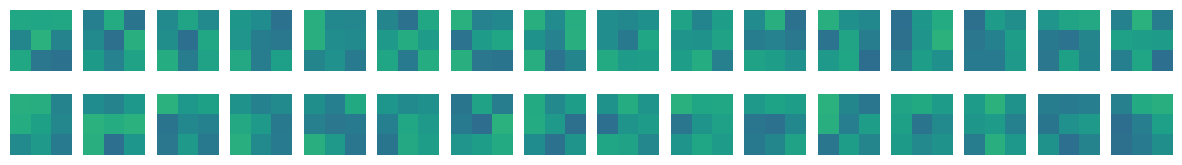

In [19]:
fig, axs = plt.subplots(2, 16, figsize=(15,2))

for i in range(2):
    for j in range(16):
        axs[i, j].imshow(no_training_weights[:,:,0,i*16 + j], vmin=-0.5, vmax=0.5)
        axs[i, j].axis('off')

plt.show()

전체적으로 가중치가 밋밋하게 초기화 되어 있음

훈련이 끝난 이전 가중치와 비교하면 합성곱 신경망이 패션 MNIST 데이터셋의 분류 정확도를 높이기 이해 유용한 패턴을 학습했다는 것을 알 수 있음

## 합성곱 신경망의 학습을 시각화하는 두번쨰 방법

### 함수형 API( Application Programming Interface)

케라스 Sequential 클래스 : 층을 차례대로 쌓은 모델

딥러닝에서는 좀 더 복잡한 모델이 존재

입력이 2개일 수도 있고 출력이 2개일 수도 있음

이러한 경우에 함수형 API(functional API)를 사용함

-----------

함수형 API는 케라스의 Model 클래스를 사용하여 모델을 만듬

예를 들어, 7장에서 만들었던 Dense 층 2개로 이루어진 완전ㄴ 연결 신경망을 함수형 API로 구현하면 다음과 같음

In [ ]:
dense1 = keras.layers.Dense(100,activation='sigmoid')
dense2 = keras.layers.Dense(10,activation='softmax')

이 두 코드는 7장과 거의 동일

이 객체를 Seequential 클래스 객체의 .add() 메소드에 전달할 수 있으나 다음과 같이 함수처럼 호출할 수 있음

In [ ]:
hidden = dense1(inputs)

파이썬의 모든 객체는 호출이 가능함

케라스의 층은 객체를 함수처럼 호출했을 때 적절히 동작할 수 있도록 미리 준비해놓음

위 코드는 입력값 inputs를 Dense 층에 통과시킨 후 출력값 hidden을 만들어줌

이런 특성이 함수형 API라고 부르게 함

두번쨰 층은 다음과 같이 호출함. 이때 첫번째 층의 출력을 입력으로 사용함

In [ ]:
outputs = dense2(hidden)

그다음 inputs와 outputs를 Model 클래스로 연결

In [ ]:
model = keras.Model(inputs,outputs)

입력에서 출력까지 층을 호출한 결과를 계속 이어주고 Model 클래스에 입력과 최종 출력을 지정

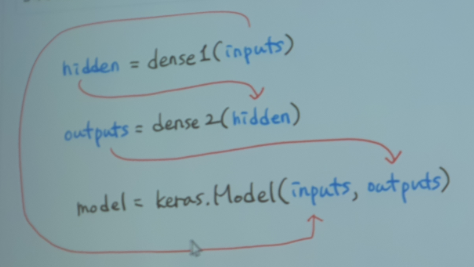

#### inputs이란?

(지금까지는 생략되었음 -> 케라스모델에서 input층(입력층)을 자동으로 설정해주기도 했고, 지금까지의 입력층은 입력을 받는 역할만을 했기 때문이다.)

8-2에서 ploy_model() 함수로 모델의 층을 도식화했을 때 InputLayer 클래스가 처음에 나왔음

Sequential 클래스는 InputLayer 클래스를 자동으로 추가하고 호출함

그러나 <b>Model 클래스에서는 수동으로 만들어서 호출해야함</b>

이 inputs가 InputLayer 클래스의 출력값이 되어야함

------------

#### Sequential 클래스에서 InputLayer의 객체는 어디에 저장되는가?

케라스 모델은 layers 속성 외에 InputLater 객체를 포함한 _self_tracked_trackables 리스트 속성을 가지고 있음

Sequential클래스 객체의 _self_tracked_trackables 속성의 첫번째 항목이 InputLayer 클래스의 객체임

InputLayer 클래스는 신경망의 입력층 역할을 함

즉, 모델의 입력을 첫번쨰 은닉층에 전달하는 역할을 수행

따라서 InputLayer 객체의 입력과 출력은 동일함


---------------

inputs을 지정하기 위해 input() 함수를 입력의 크기를 지정하는 shape 매개변수와 함께 사용

```python
inputs = keras.Input(shape=(784,))
```

마치 체인처럼 입력에서 출력까지 연결하고 마지막에 Model 클래스에 입력과 출력을 지정하여 모델을 만듬

이렇게 모델을 만들면 중간에 다양한 형채로 층을 연결할 수 있음

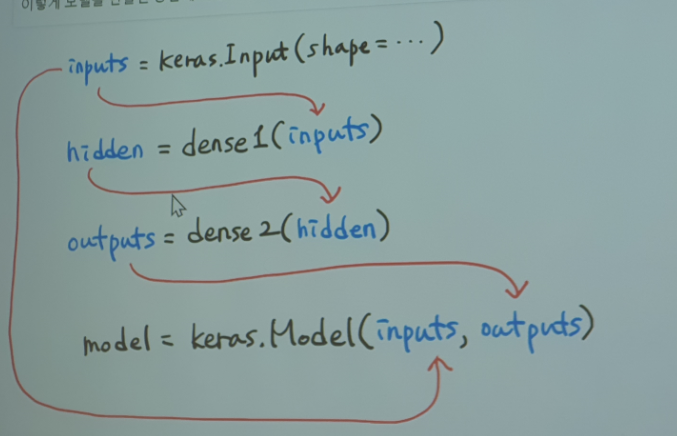

### 특성 맵 시각화를 만드는데 함수형 API가 필요한 이유?

8-2에서 정의한 model 객체의 층을 순서대로 나열하면 다음과 같음

InputLayer -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Flatten -> Dense -> Dropout-> Dense

첫번째 Conv2D의 출력을 알고 싶다면, model 객체의 입력과 Conv2D의 출력을 이용해 새로운 모델을 만들고 이를 이용


```python
conv_acti = keras.Model(model.input, model.layers[0].output)

```

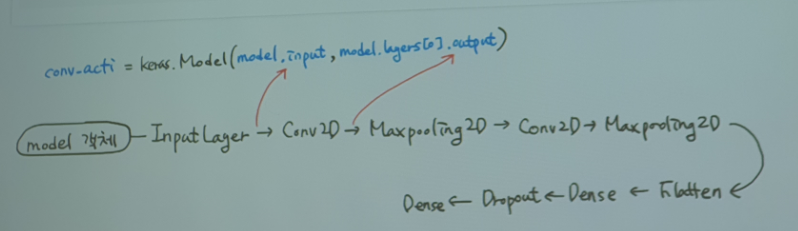

model 객체의 predict() 메소드를 호출하면 입력부터 마지막 층까지 모든 계산을 수행한 후 최종 출력을 반환함

그러나 필요한 것은 첫번째 Conv2D 층이 출력한 특성맵

첫번쨰 층의 출력은 Conv2D객체의 output속성에서 얻을 수 있음

이것은 model.layers[0].output처럼 참조 가능

model 객체인 입력은 input속성으로 알 수 있음 ( 케라스 모델은 input 속성으로 입력을 참조할 수 있음 )

model.input을 사용하면 됨

In [20]:
print(model.input)

KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='conv2d_7_input'), name='conv2d_7_input', description="created by layer 'conv2d_7_input'")


model.input과 model.layers[0].output을 연결하는 새로운 conv_acti 모델을 다음과 같이 생성

In [21]:
conv_acti = keras.Model(model.input, model.layers[0].output)

model 객체의 predict() 메소드를 호출하면 최종 출력층의 확률을 반환

conv_acti의 predict() 메소드를 호출하면 첫번쨰 Conv2D의 출력을 반환

### 특성 맵 시각화

패션 MNIST 데이터셋의 훈련 세트에 있는 첫번째 샘플 그려보기

In [22]:
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


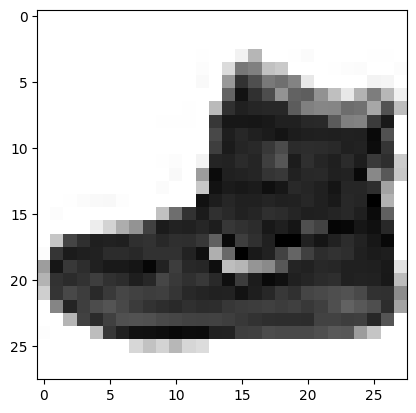

In [23]:
plt.imshow(train_input[0], cmap='gray_r')
plt.show()

앵클 부츠

이 샘플을 conv_acti 모델에 주입하여 Conv2D 층이 만드는 특성 맵을 출력해보자

In [24]:
inputs = train_input[0:1].reshape(-1, 28, 28, 1)/255.0

feature_maps = conv_acti.predict(inputs)

1/1 [==============================] - 7s 7s/step


세임 패딩과 32개의 필터를 사용한 합성곱 층의 출력이므로 (28,28,32) 크기를 가진다.

첫번쨰 차원은 배치크기를 나타내는 배치 차원이며, 샘플 하나를 입력했기 떄문에 1이다.

배치 차원 데이터를 미니배치(mini-batch)단위로 나누어 처리할 떄 사용되는 차원

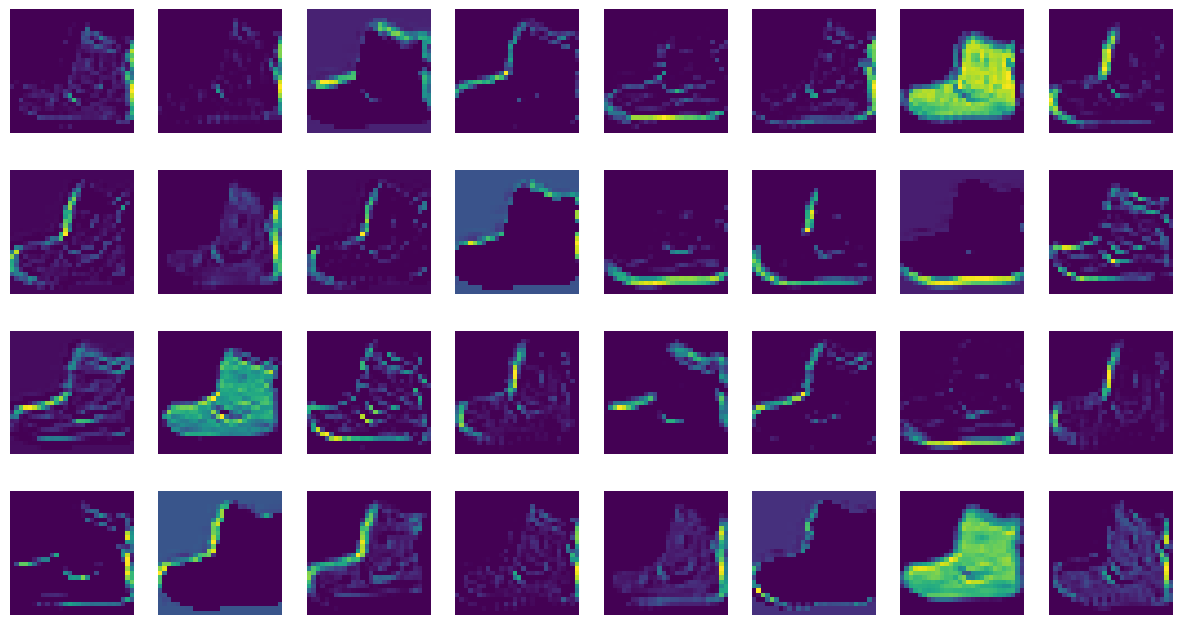

In [25]:
fig, axs = plt.subplots(4, 8, figsize=(15,8))

for i in range(4):
    for j in range(8):
        axs[i, j].imshow(feature_maps[0,:,:,i*8 + j])
        axs[i, j].axis('off')

plt.show()

32개의 필터로 인해 입력 이미지에서 강하게 활성화된 부분을 보여주며, 비교를 위해 필터를 다시 출력함

첫번째 줄의 7번쨰 그리고 네번째 줄의 4번쨰 필터들은 전체적으로 밝은 색이므로 전면이 모두 칠해진 영역을 감지함

반대로 두번째 줄의 6번쨰 필터는 전체적으로 낮은 음수값이며, 이 필터와 큰 양수가 곱해지면 더 큰 음수가 되고 배경처럼 0에 가까운 값과 곱해지면 작은 음수가 됨

즉 부츠의 배경이 상대적으로 크게 활성화 될 수 있음

첫번쨰 줄의 8번쨰 필터는 오른쪽의 수직선을 감지하므로 이 필터가 감지한 수직선이 강하게 활성화 되어 있음

두번쨰 합성곱 층의 특성 맵 확인

입력층부터 시작하여 첫번쨰 합성곱 층, 첫번쨰 맥스풀링층, 두번쨰 합성곱 층을 통과함

In [28]:
conv2_acti = keras.Model(model.input, model.layers[2].output)

In [29]:
feature_maps = conv2_acti.predict(train_input[0:1].reshape(-1, 28, 28, 1)/255.0)

1/1 [==============================] - 0s 128ms/step


In [30]:
print(feature_maps.shape)

(1, 14, 14, 64)


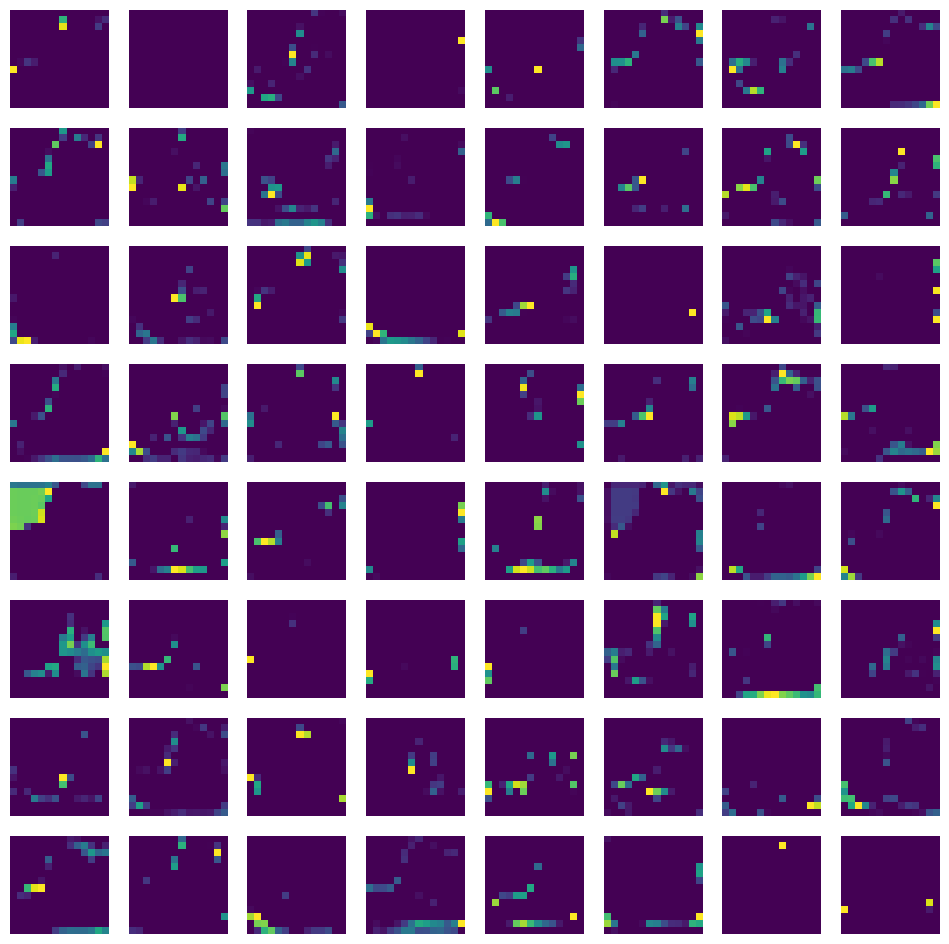

In [31]:
fig, axs = plt.subplots(8, 8, figsize=(12,12))

for i in range(8):
    for j in range(8):
        axs[i, j].imshow(feature_maps[0,:,:,i*8 + j])
        axs[i, j].axis('off')

plt.show()

시각적으로 이해하기 힘듬

두번째 합성곱 층의 필터 크기는 (3,3,32)

두번쨰 합성곱 층의 첫번째 필터가 앞서 출력한 32개의 특성맵과 곱해져 두번쨰 합성곱 층의 첫번쨰 특성맵이됨

이렇게 계산된 출력은 (14,14,32)특성맵에서 어떤 부위를 감지하는지 직관적으로 이해하기 어려움

이러한 현상은 합성곱 층을 많이 쌓을수록 심해짐

이를 바꾸어 생각하면 합성곱 신경망의 앞부분에 있는 합성곱 층은 이미지의 시각적인 정보를 감지하고 뒤쪽에 있는 합성곱 층은 앞쪽에서 감지한 시각적인 정보를 바탕으로 추상적인 정보를 학습한다고 볼 수 있음

이것이 합성곱 신경망이 패션 MNIST 이미지를 인식하여 10개의 클래스를 찾아낼 수 있는 이유임